In [18]:
library(dplyr)
library(ggplot2)
library(reshape2)

# install.packages("Cairo")
library(Cairo)

options(warn=0)


Installing package into ‘/Users/Collier/Library/R/3.3/library’
(as ‘lib’ is unspecified)



The downloaded binary packages are in
	/var/folders/lm/_1_17w790vl16h7mp5sz_cf80000gn/T//Rtmp2W8Rwf/downloaded_packages


https://www.r-bloggers.com/sales-funnel-visualization-with-r/

## Customer Journey DF

Sales (purchasing or conversion) Funnel is a consumer-focused marketing model which illustrates the theoretical customer journey towards the purchase of a product or service. Classically, the Sales funnel includes at least four steps:

**Awareness** – the customer becomes aware of the existence of a product or service.

**Interest** – actively expressing an interest in a product group.

**Desire** – aspiring to a particular brand or product.

**Action** – taking the next step towards purchasing the chosen product.

### Journey Steps

If we speak about e-commerce, we can use content of the site for defining steps. 

* Let’s assume that our main page and landing pages of ad campaigns are responsible for the **Awareness** step. 

* The pages with product or service descriptions correspond to the **Interest** from customers. 

* Shopping cart page confirms the **Desire**. 

* Finally, the conversion page (“thank you page”) is the **Action**. In other words, our theoretical customer journey looks like the following:

In [19]:
# creating a data samples
# content
df.content <- data.frame(
    content = c('main', 'ad landing','product 1', 'product 2', 'product 3', 'product 4','shopping cart','thank you page'),
    step = c('awareness', 'awareness','interest', 'interest', 'interest', 'interest','desire','action'),
    number = c(150000, 80000, 80000, 40000, 35000, 25000, 130000,120000)
)

df.content

,content,step,number
1,main,awareness,150000
2,ad landing,awareness,80000
3,product 1,interest,80000
4,product 2,interest,40000
5,product 3,interest,35000
6,product 4,interest,25000
7,shopping cart,desire,130000
8,thank you page,action,120000


## Customers LifeCycle DF

In [20]:
# customers
df.customers <- data.frame(
    content = c('new', 'engaged', 'loyal'),
    step = c('new', 'engaged', 'loyal'),
    number = c(25000, 40000, 55000)
)

In [21]:
df.customers

,content,step,number
1,new,new,25000
2,engaged,engaged,40000
3,loyal,loyal,55000


## Combining

In [22]:
# combining two data sets
df.all <- rbind(df.content, df.customers)

In [23]:
df.all

,content,step,number
1,main,awareness,150000
2,ad landing,awareness,80000
3,product 1,interest,80000
4,product 2,interest,40000
5,product 3,interest,35000
6,product 4,interest,25000
7,shopping cart,desire,130000
8,thank you page,action,120000
9,new,new,25000
10,engaged,engaged,40000


## Calculate Dummy Variables

In [24]:
# calculating dummies, max and min values of X for plotting
df.all <- df.all %>%
group_by(
    step) %>%
mutate(
    totnum = sum(number)) %>%
ungroup() %>%
mutate(
    dum = (max(totnum) - totnum)/2,
    maxx = totnum + dum,
    minx = dum)

df.all

,content,step,number,totnum,dum,maxx,minx
1,main,awareness,150000,230000,0,230000,0
2,ad landing,awareness,80000,230000,0,230000,0
3,product 1,interest,80000,180000,25000,205000,25000
4,product 2,interest,40000,180000,25000,205000,25000
5,product 3,interest,35000,180000,25000,205000,25000
6,product 4,interest,25000,180000,25000,205000,25000
7,shopping cart,desire,130000,130000,50000,180000,50000
8,thank you page,action,120000,120000,55000,175000,55000
9,new,new,25000,25000,102500,127500,102500
10,engaged,engaged,40000,40000,95000,135000,95000


## DF for Plotting Funnel Lines

In [25]:
#  data frame for plotting funnel lines
df.lines <- df.all %>%
select(step, maxx, minx) %>%
group_by(step) %>%
unique()

df.lines

,step,maxx,minx
1,awareness,230000,0
2,interest,205000,25000
3,desire,180000,50000
4,action,175000,55000
5,new,127500,102500
6,engaged,135000,95000
7,loyal,142500,87500


## DF with Dummies

In [26]:
# data frame with dummies
df.dum <- df.all %>%
select(step, dum) %>%
unique() %>%
mutate(content = 'dummy',
number = dum) %>%
select(content, step, number)

df.dum

,content,step,number
1,dummy,awareness,0
2,dummy,interest,25000
3,dummy,desire,50000
4,dummy,action,55000
5,dummy,new,102500
6,dummy,engaged,95000
7,dummy,loyal,87500


## DF with Conv Rates

In [27]:
# data frame with rates
conv <- df.all$totnum[df.all$step == 'action']
 
df.rates <- df.all %>%
select(step, totnum) %>%
group_by(step) %>%
unique() %>%
ungroup() %>%
mutate(prevnum = lag(totnum),
rate = ifelse(step == 'new' | step == 'engaged' | step == 'loyal',
round(totnum / conv, 3),
round(totnum / prevnum, 3))) %>%
select(step, rate)
df.rates <- na.omit(df.rates)

df.rates

,step,rate
1,interest,0.783
2,desire,0.722
3,action,0.923
4,new,0.208
5,engaged,0.333
6,loyal,0.458


## DF Final

In [28]:
df.all <- df.all %>%
select(content, step, number)
 
df.all <- rbind(df.all, df.dum)
 
df.all <- df.all %>%
group_by(step) %>%
arrange(desc(content)) %>%
ungroup()

df.all

,content,step,number
1,dummy,awareness,0
2,dummy,interest,25000
3,dummy,desire,50000
4,dummy,action,55000
5,dummy,new,102500
6,dummy,engaged,95000
7,dummy,loyal,87500
8,new,new,25000
9,loyal,loyal,55000
10,engaged,engaged,40000


In [29]:
# calculating position of labels
df.all <- df.all %>%
group_by(step) %>%
mutate(pos = cumsum(number) - 0.5*number)

df.all

,content,step,number,pos
1,dummy,awareness,0,0
2,dummy,interest,25000,12500
3,dummy,desire,50000,25000
4,dummy,action,55000,27500
5,dummy,new,102500,51250
6,dummy,engaged,95000,47500
7,dummy,loyal,87500,43750
8,new,new,25000,115000
9,loyal,loyal,55000,115000
10,engaged,engaged,40000,115000


In [30]:
# defining order of steps
df.all$step <- factor(df.all$step, levels = c('loyal', 'engaged', 'new', 'action', 'desire', 'interest', 'awareness'))
list <- c(unique(as.character(df.all$content)))
df.all$content <- factor(df.all$content, levels = c('dummy', c(list)))

df.all

Warning message:
In `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, : duplicated levels in factors are deprecated

,content,step,number,pos
1,dummy,awareness,0,0
2,dummy,interest,25000,12500
3,dummy,desire,50000,25000
4,dummy,action,55000,27500
5,dummy,new,102500,51250
6,dummy,engaged,95000,47500
7,dummy,loyal,87500,43750
8,new,new,25000,115000
9,loyal,loyal,55000,115000
10,engaged,engaged,40000,115000


In [31]:
# creating custom palette with 'white' color for dummies
cols <- c("#ffffff", "#fec44f", "#fc9272", "#a1d99b", "#fee0d2", "#2ca25f",
"#8856a7", "#43a2ca", "#fdbb84", "#e34a33",
"#a6bddb", "#dd1c77", "#ffeda0", "#756bb1")

In [35]:
df.all

,content,step,number,pos
1,dummy,awareness,0,0
2,dummy,interest,25000,12500
3,dummy,desire,50000,25000
4,dummy,action,55000,27500
5,dummy,new,102500,51250
6,dummy,engaged,95000,47500
7,dummy,loyal,87500,43750
8,new,new,25000,115000
9,loyal,loyal,55000,115000
10,engaged,engaged,40000,115000


In [43]:
# df.lines

Warning message:
In `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, : duplicated levels in factors are deprecated

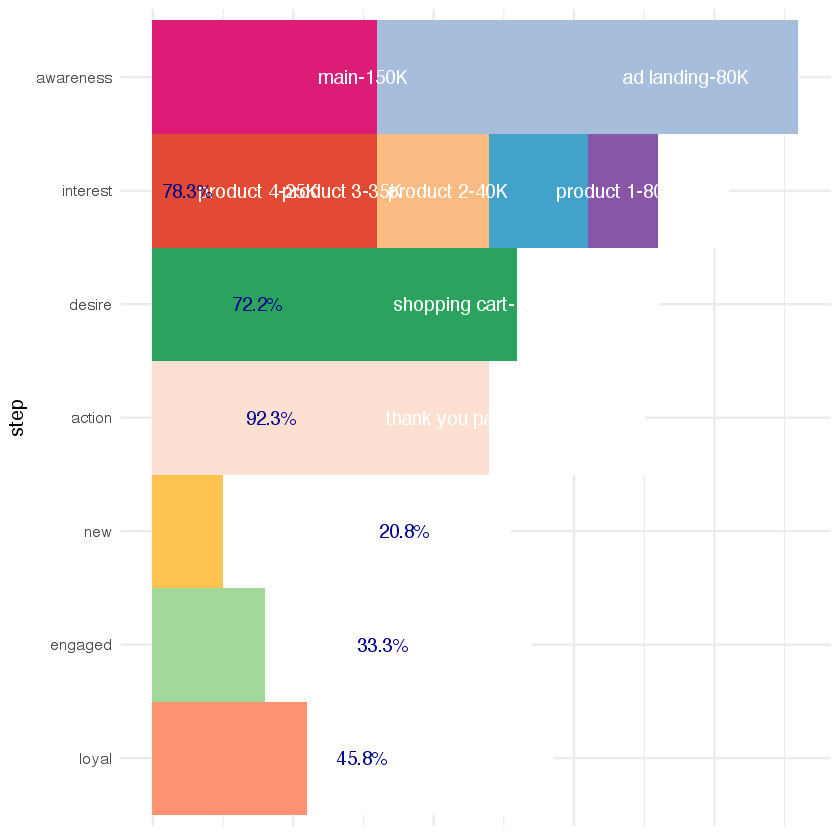

In [51]:
# plotting chart
ggplot() +
theme_minimal() +
coord_flip() +
scale_fill_manual(values=cols) +
geom_bar(data=df.all, aes(x=step, y=number, fill=content), stat="identity", width=1) +
geom_text(data=df.all[df.all$content!='dummy', ],
aes(x=step, y=pos, label=paste0(content, '-', number/1000, 'K')),
size=4, color='white', fontface="bold") +
# geom_ribbon(data=df.lines, aes(x=step, ymax=max(maxx), ymin=maxx, group=1), fill='white') +
# geom_line(data=df.lines, aes(x=step, y=maxx, group=1), color='darkred', size=4) +
# geom_ribbon(data=df.lines, aes(x=step, ymax=minx, ymin=min(minx), group=1), fill='white') +
# geom_line(data=df.lines, aes(x=step, y=minx, group=1), color='darkred', size=4) +
geom_text(data=df.rates, aes(x=step, y=(df.lines$minx[-1]), label=paste0(rate*100, '%')), hjust=1.2,
color='darkblue', fontface="bold") +
theme(legend.position='none', axis.ticks=element_blank(), axis.text.x=element_blank(),
axis.title.x=element_blank())